### Import

In [17]:
!pip install category_encoders

In [18]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm

import plotly.express as px

import category_encoders as ce
from sklearn.ensemble import AdaBoostClassifier

In [19]:
# 동일한 결과 보장을 위해 Seed값을 고정합니다
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed를 42로 고정

In [20]:
train = pd.read_csv('train.csv', nrows = 300000)

# 제공된 train 데이터와 test 데이터를 불러옵니다
test = pd.read_csv('test.csv')

### EDA 1 : Sparse and Dense

In [21]:
train.head()

,ID,Click,F01,F02,F03,F04,F05,F06,F07,F08,...,F30,F31,F32,F33,F34,F35,F36,F37,F38,F39
0,TRAIN_00000000,1,NSLHFNS,AVKQTCL,DTZFPRW,114.0,ISVXFVA,1,PQZBVMG,LPYPUNA,...,NZGEZLW,GTISJWW,380.0,2.0,AXQFZWC,IRUDRFB,NaN,TFJMLCZ,0.0,AURZYDY
1,TRAIN_00000001,0,VGIVWZQ,LSUSMVO,PQGWFJZ,26.0,NFRVLWS,43,IMPIGJT,MIGYEEG,...,NZGEZLW,GTISJWW,466.0,1.0,DRVVDHZ,IRUDRFB,19.0,AUGTURV,0.0,LUZRMLU
2,TRAIN_00000002,0,JCDXFYU,PILDDJU,IAGJDOH,119.0,LFPUEOV,0,FFUTIRZ,OFKQGTY,...,VHXETCF,KHZNEZF,197.0,0.0,QMOULXS,IRUDRFB,8.0,ZVSTLNM,0.0,MHBRSQK
3,TRAIN_00000003,1,PSMFWTP,ZYAVJHP,NaN,15.0,ATQPZSJ,26,ZDTZNSB,THBWWCD,...,IVIRTPR,GTISJWW,8640.0,0.0,IZLJUJS,IRUDRFB,14.0,ZBSRLCQ,0.0,GAZBSSZ
4,TRAIN_00000004,0,SLCRICD,QPQWGXA,NaN,13.0,CHZGJZR,20,PQZBVMG,MIGYEEG,...,NZGEZLW,WHSRKIM,41774.0,0.0,BHBIZCL,IRUDRFB,13.0,QHYLSBX,0.0,QTATWAY


In [22]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 41 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ID      300000 non-null  object 
 1   Click   300000 non-null  int64  
 2   F01     288023 non-null  object 
 3   F02     288023 non-null  object 
 4   F03     187013 non-null  object 
 5   F04     241070 non-null  float64
 6   F05     288023 non-null  object 
 7   F06     300000 non-null  int64  
 8   F07     300000 non-null  object 
 9   F08     300000 non-null  object 
 10  F09     300000 non-null  object 
 11  F10     288023 non-null  object 
 12  F11     271411 non-null  float64
 13  F12     288023 non-null  object 
 14  F13     300000 non-null  object 
 15  F14     300000 non-null  int64  
 16  F15     187013 non-null  object 
 17  F16     300000 non-null  object 
 18  F17     300000 non-null  object 
 19  F18     221747 non-null  float64
 20  F19     263607 non-null  float64
 21  F20     18

### EDA 2 : Imbalance

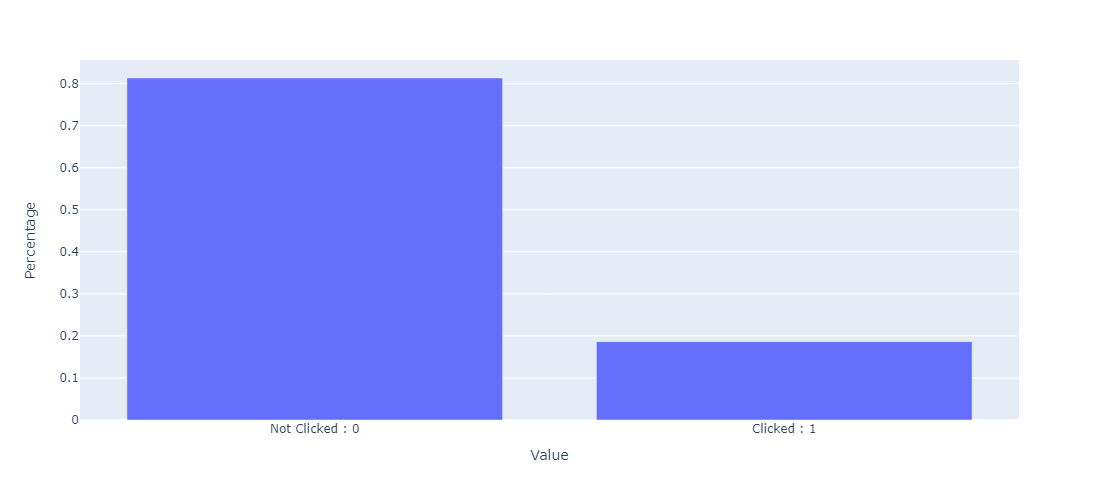

In [23]:
click = train['Click'].value_counts(normalize=True)

click_figure = px.bar(click,
             x=['Not Clicked : 0', 'Clicked : 1'],
             y=click.values.tolist(),
             labels={'x': 'Value', 'y': 'Percentage'},
             width = 450,
             height = 500
            )

# 그래프 표시
click_figure.show()

### Data Preprocessing 1 : Select x, y

In [24]:
train_x = train.drop(columns=['ID', 'Click'])
train_y = train['Click']

test_x = test.drop(columns=['ID'])

### Data Preprocessing 2 : Fill NaN

In [25]:
for col in tqdm(train_x.columns):
    if train_x[col].isnull().sum() != 0:
        train_x[col].fillna(0, inplace=True)
        test_x[col].fillna(0, inplace=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 19.66it/s]


### Data Preprocessing 3 : Count Encoding

In [26]:
encoding_target = list(train_x.dtypes[train_x.dtypes == "object"].index)

enc = ce.CountEncoder(cols = encoding_target).fit(train_x, train_y)
X_train_encoded = enc.transform(train_x)
X_test_encoded = enc.transform(test_x)

### Model Setting

In [27]:
model = AdaBoostClassifier()

### Model Train and Inference

In [28]:
model.fit(X_train_encoded, train_y)

AdaBoostClassifier()

In [29]:
pred = model.predict_proba(X_test_encoded)
display(model.classes_)
display(pred)

array([0, 1], dtype=int64)

array([[0.50352093, 0.49647907],
       [0.50850995, 0.49149005],
       [0.50801291, 0.49198709],
       ...,
       [0.51093577, 0.48906423],
       [0.50727684, 0.49272316],
       [0.50621391, 0.49378609]])

### Submission

In [30]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission

,ID,Click
0,TEST_0000000,0
1,TEST_0000001,0
2,TEST_0000002,0
3,TEST_0000003,0
4,TEST_0000004,0
...,...,...
4538536,TEST_4538536,0
4538537,TEST_4538537,0
4538538,TEST_4538538,0
4538539,TEST_4538539,0


In [31]:
sample_submission['Click'] = pred[:,1]
sample_submission

,ID,Click
0,TEST_0000000,0.496479
1,TEST_0000001,0.491490
2,TEST_0000002,0.491987
3,TEST_0000003,0.494542
4,TEST_0000004,0.498733
...,...,...
4538536,TEST_4538536,0.488727
4538537,TEST_4538537,0.495640
4538538,TEST_4538538,0.489064
4538539,TEST_4538539,0.492723


In [32]:
sample_submission.to_csv('baseline_submission.csv', index=False)